In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Particle Filter



The particle filter addresses the same state estimation problem as the Kalman filter but uses a Monte Carlo approach that can handle non-linear dynamics and non-Gaussian noise distributions.

Suppose the state evolution follows:
\begin{equation}
x_k = f(x_{k-1}, u_{k-1}) + w_{k-1}
\end{equation}
where $f(\cdot)$ is a potentially non-linear state transition function, $u_{k-1}$ is the control input, and $w_{k-1}$ is process noise that can follow any distribution.

Measurements are related to the state via:
\begin{equation}
z_k = h(x_k) + v_k
\end{equation}
where $h(\cdot)$ is a potentially non-linear observation function and $v_k$ is measurement noise.


The particle filter represents the posterior distribution $p(x_k|z_{1:k})$ using a set of $N$ weighted particles $\{x_k^{(i)}, w_k^{(i)}\}_{i=1}^N$

### Algorithim

1. Prediction:  Sample new particles from the motion model:
\begin{equation}
x_k^{(i)} \sim p(x_k|x_{k-1}^{(i)}, u_{k-1})
\end{equation}

2. Update: Compute importance weights based on measurement likelihood:
\begin{equation}
w_k^{(i)} \propto w_{k-1}^{(i)} \cdot p(z_k|x_k^{(i)})
\end{equation}

3. Resampling: Resample particles according to their weights to prevent degeneracy.


The key advantage over the Kalman filter is that particle filters can handle arbitrary non-linearities and noise distribution. 

<div style="text-align: center;">
<img src="Particle_Filter.png" alt="Timeseries" width="500"/>
<\div>

In [2]:
import numpy as np

def multinormal_pdf(x, mean, cov):
    """
    Multivariate normal PDF at x, with given mean and cov.
    x, mean are (d,) arrays; cov is (d,d).
    """
    d = x.shape[0]
    dev = x - mean
    invc = np.linalg.inv(cov)
    exponent = -0.5 * dev.T @ invc @ dev
    norm = np.sqrt((2*np.pi)**d * np.linalg.det(cov))
    return np.exp(exponent) / norm

def particle_filter(N, f, h, Q, R, y, x0_particles, N_thresh=None):
    # make sure 'y' is (T, obs_dim)
    T = y.shape[0]
    obs = y.reshape(T, -1)             # now shape (T, obs_dim)
    obs_dim   = obs.shape[1]
    state_dim = x0_particles.shape[1]

    if N_thresh is None:
        N_thresh = N/2

    particles     = x0_particles.copy()      # (N, state_dim)
    weights       = np.ones(N)/N
    x_est         = np.zeros((T, state_dim))
    particles_all = np.zeros((T, N, state_dim))
    weights_all   = np.zeros((T, N))

    # time 0
    x_est[0]            = np.average(particles, axis=0, weights=weights)
    particles_all[0]    = particles.copy()
    weights_all[0]      = weights.copy()

    for t in range(1, T):
        # 1) predict
        x_pred = np.zeros_like(particles)
        for i in range(N):
            x_k       = f(particles[i])  # particles[i] holds our sample of the state at t−1 (i.e. μₜ₋₁)
            x_pred[i] = x_k + np.random.multivariate_normal(
                            np.zeros(state_dim), Q)

        # 2) weight update
        new_w = np.zeros(N)
        for i in range(N):
            z_mean    = h(x_pred[i])    
            new_w[i]  = weights[i] * multinormal_pdf(
                              obs[t],    
                              z_mean,
                              R)

        # 3) normalize (with degeneracy check)
        s = new_w.sum()
        if s < 1e-30:
            weights = np.ones(N)/N
        else:
            weights = new_w / s

        # 4) state estimate
        x_est[t] = np.average(x_pred, axis=0, weights=weights)

        # 5) resample if needed
        N_eff = 1.0/np.sum(weights**2)
        if N_eff < N_thresh:
            idx       = np.random.choice(N, size=N, p=weights)
            particles = x_pred[idx]
            weights   = np.ones(N)/N
        else:
            particles = x_pred

        particles_all[t] = particles
        weights_all[t]   = weights

    return x_est, particles_all, weights_all

In [3]:
def weighted_quantile(values, weights, q):
    """
    Compute the q-th weighted quantile of `values` with given `weights`.
    q in [0,1].
    """
    sorter = np.argsort(values)
    v = values[sorter]
    w = weights[sorter]
    cw = np.cumsum(w)
    cw /= cw[-1]
    return np.interp(q, cw, v)

# Local-Level Model

#### State Equation

$$ \mu_t = \mu_{t-1} + \eta_t, \quad \eta_t \sim N(0, \sigma_\eta^2)$$ 

#### Observation Equation

$$ y_t = \mu_t + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma_\varepsilon^2)$$ 

Here, $A=1$, $H=1$, $Q = \sigma^2_\eta$ and $R = \sigma^2_\varepsilon$

In [4]:
def f(x, u=None):
    return x

def h(x):
    return x

In [5]:
# Simulate data
np.random.seed(42)
T = 100
mu_true = np.zeros(T)
mu_true[0] = 0  # Initial state
sigma_eta = 0.5
sigma_eps = 1.0

for t in range(1, T):
    mu_true[t] = mu_true[t-1] + np.random.normal(0, sigma_eta)

y = mu_true + np.random.normal(0, sigma_eps, T)

In [ ]:
#   N particles, initial draw from a diffuse prior
N = 1000
x0_particles = np.random.normal(0, 1, size=(N, 1))  

#   process and measurement noise covariances
Q = np.array([[sigma_eta**2]])
R = np.array([[sigma_eps**2]])

mu_est, particles_all, weights_all = particle_filter(
    N, f, h, Q, R,
    y,
   x0_particles
)

lower = np.zeros(T)
upper = np.zeros(T)

for t in range(T):
    vals = particles_all[t,:,0]   
    wts  = weights_all[t]
    lower[t] = weighted_quantile(vals, wts, 0.025)
    upper[t] = weighted_quantile(vals, wts, 0.975)

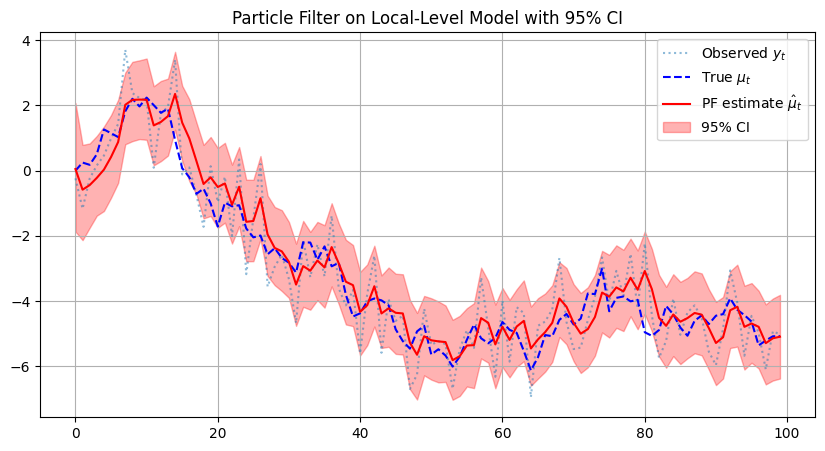

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y,        linestyle=':',  alpha=0.5, label='Observed $y_t$')
plt.plot(mu_true,  linestyle='--', color='blue', label='True $\\mu_t$')
plt.plot(mu_est,   color='r',     label='PF estimate $\\hat{\\mu}_t$')
plt.fill_between(range(T), lower, upper,
                 color='r', alpha=0.3, label='95% CI')
plt.title('Particle Filter on Local‐Level Model with 95% CI')
plt.legend()
plt.grid(True)
plt.show()

# Local-Level with trend

\begin{align*}
\mu_k &= \mu_{k-1} + \beta_{k-1} + \eta_k, \quad \quad  \eta_k \sim \mathcal{N}(0, \sigma_\eta^2)\\
\beta_k &= \beta_{k-1} + \zeta_k, \qquad \qquad \quad  \zeta_k \sim \mathcal{N}(0, \sigma_\zeta^2)
\end{align*}


#### Observation Equation:

$$y_k = \mu_k + \varepsilon_k, \quad \varepsilon_k \sim \mathcal{N}(0, \sigma_\varepsilon^2)$$

Notice, 
$$ 
x_k = \begin{bmatrix} \mu_k \\ \beta_k \end{bmatrix},\; A = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix},\; Q = \begin{bmatrix} \sigma_\eta^2 & 0 \\ 0 & \sigma_\zeta^2 \end{bmatrix}, \; H = \begin{bmatrix} 1 & 0 \end{bmatrix}
$$

In [ ]:
np.random.seed(42)
T = 100

# True parameters
sigma_eta = 0.2
sigma_zeta = 0.05
sigma_eps = 1.0

# Simulate state and observation
mu_true   = np.zeros(T)
beta_true = np.zeros(T)
y         = np.zeros(T)

for t in range(1, T):
    mu_true[t]   = mu_true[t-1]   + np.random.normal(0, sigma_eta)
    beta_true[t] = beta_true[t-1] + np.random.normal(0, sigma_zeta)
    y[t]         = mu_true[t] + beta_true[t] + np.random.normal(0, sigma_eps)

observations = y.reshape(T,1)   # need shape (T, obs_dim=1)


In [ ]:
def f(x):
    # x is a length-2 array [mu_{t-1}, beta_{t-1}]
    return x
def h(x):
    # x is [mu_t, beta_t]
    return np.array([ x[0] + x[1] ])   # returns a length-1 array so shapes line up

In [ ]:
# — set Q, R, initial particles —
Q = np.diag([sigma_eta**2, sigma_zeta**2])
R = np.array([[sigma_eps**2]])

N = 1000
# draw initial particles from a diffuse prior
x0_particles = np.random.multivariate_normal(mean=[0,0], cov=np.diag([1,1]), size=N)

# — run PF —
x_est, particles_all, weights_all = particle_filter(
    N, f, h, Q, R,
    observations,
    x0_particles
)


mu_est   = x_est[:,0]
beta_est = x_est[:,1]

lower_mu = np.zeros(T); upper_mu = np.zeros(T)
lower_bt = np.zeros(T); upper_bt = np.zeros(T)

for t in range(T):
    mu_samps   = particles_all[t,:,0]
    beta_samps = particles_all[t,:,1]
    wts        = weights_all[t]

    lower_mu[t]   = weighted_quantile(mu_samps,   wts, 0.025)
    upper_mu[t]   = weighted_quantile(mu_samps,   wts, 0.975)
    lower_bt[t]   = weighted_quantile(beta_samps, wts, 0.025)
    upper_bt[t]   = weighted_quantile(beta_samps, wts, 0.975)

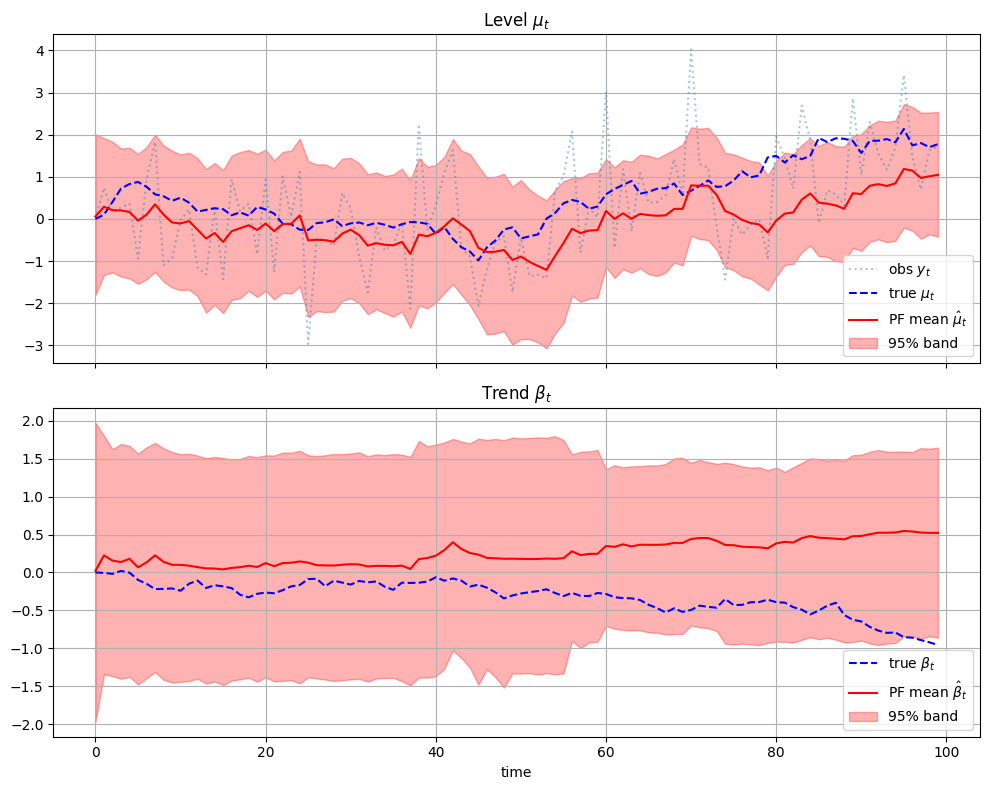

In [ ]:


# — plot everything —
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

# μ panel
axs[0].plot(y,          linestyle=':', alpha=0.4, label='obs $y_t$')
axs[0].plot(mu_true,    '--', color='blue',      label='true $\mu_t$')
axs[0].plot(mu_est,     '-', color='r',         label='PF mean $\hat\mu_t$')
axs[0].fill_between(range(T),
                    lower_mu, upper_mu,
                    color='r', alpha=0.3,      label='95% band')
axs[0].set_title('Level $\mu_t$')
axs[0].legend(); axs[0].grid(True)

# β panel
axs[1].plot(beta_true,  '--', color='blue',      label='true $\\beta_t$')
axs[1].plot(beta_est,   '-', color='r',         label='PF mean $\\hat\\beta_t$')
axs[1].fill_between(range(T),
                    lower_bt, upper_bt,
                    color='r', alpha=0.3,      label='95% band')
axs[1].set_title('Trend $\\beta_t$')
axs[1].legend(); axs[1].grid(True)

plt.xlabel('time')
plt.tight_layout()


# Linear Regression with Time-varying paramaters

let, 
$$ y_t = \alpha_t + \beta_t x_t + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma_\varepsilon^2)$$ 
where, 
$$ \begin{aligned}
\alpha_t &= \alpha_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_\alpha^2) \\
\beta_t &= \beta_{t-1} + \zeta_t, \quad \zeta_t \sim \mathcal{N}(0, \sigma_\beta^2)
\end{aligned}$$

This means, 
$$ x_t = \begin{bmatrix} \alpha_t \\ \beta_t \end{bmatrix}, \; A = I_2, \; Q = \text{diag}(\sigma_\alpha^2, \sigma_\beta^2), \; R = \sigma_\varepsilon^2, \;H = y_t = \begin{bmatrix} 1 & x_t^{(obs)} \end{bmatrix} x_t + \varepsilon_t$$

In [ ]:
np.random.seed(42)
T = 100
x_obs = np.linspace(0, 10, T)

# True time-varying coefficients
alpha_true = np.cumsum(np.random.normal(0, 0.1, T))
beta_true = 1 + 0.5 * np.sin(np.linspace(0, 3*np.pi, T))

# Generate observations
y = alpha_true + beta_true * x_obs + np.random.normal(0, 1.0, T)
observations = y.reshape(T, 1)   # need shape (T, obs_dim=1)

In [ ]:
def f(x, u=None):
    return x

def h(x, t):
    # given state = [alpha, beta], return E[y_t]
    return np.array([ x[0] + x[1]*x_obs[t] ])

In [ ]:
def multinormal_pdf(x, mean, cov):
    d = x.shape[0]
    dev = x-mean
    invc = np.linalg.inv(cov)
    exponent = -0.5 * dev.T @ invc @ dev
    norm = np.sqrt((2*np.pi)**d * np.linalg.det(cov))
    return np.exp(exponent)/norm

def particle_filter(N, f, h, Q, R, y, x0_particles, N_thresh=None):
    T = len(y)
    obs = y.reshape(T,1)
    if N_thresh is None:
        N_thresh = N/2
    
    particles = x0_particles.copy()       
    weights   = np.ones(N)/N
    x_est     = np.zeros((T, state_dim))
    particles_all = np.zeros((T, N, state_dim))
    weights_all   = np.zeros((T, N))
    
    # time 0
    x_est[0] = np.average(particles, axis=0, weights=weights)
    particles_all[0], weights_all[0] = particles.copy(), weights.copy()
    
    for t in range(1, T):
        # 1) predict
        x_pred = np.zeros_like(particles)
        for i in range(N):
            mu = f(particles[i], None)
            x_pred[i] = mu + np.random.multivariate_normal(np.zeros(state_dim), Q)
        
        # 2) weight update
        new_w = np.zeros(N)
        for i in range(N):
            z_mean = h(x_pred[i], t)               # now depends on t
            new_w[i] = weights[i] * multinormal_pdf(obs[t], z_mean, R)
        
        # 3) normalize
        s = new_w.sum()
        if s < 1e-30:
            # degeneracy rescue
            weights = np.ones(N)/N
        else:
            weights = new_w/s
        
        # 4) state estimate
        x_est[t] = np.average(x_pred, axis=0, weights=weights)
        
        # 5) resample if needed
        N_eff = 1.0/np.sum(weights**2)
        if N_eff < N_thresh:
            idx = np.random.choice(N, size=N, p=weights)
            particles = x_pred[idx]
            weights   = np.ones(N)/N
        else:
            particles = x_pred
        
        particles_all[t] = particles
        weights_all[t]   = weights
    
    return x_est, particles_all, weights_all


In [ ]:
N = 2000                      # number of particles
Q = np.diag([sigma_eta**2, sigma_zeta**2])  # state noise cov
R = np.array([[sigma_eps**2]])             # obs noise cov

# 4) initialize particles at t=0
state_dim = 2
x0_mean   = np.array([0.0, 1.0])
x0_cov    = np.diag([1.0, 1.0])
x0_particles = np.random.multivariate_normal(x0_mean, x0_cov, size=N)

x_est, particles_all, weights_all = particle_filter(
    N, f, h, Q, R, y, x0_particles, N_thresh=N/2
)

alpha_est = x_est[:,0]
beta_est  = x_est[:,1]

alpha_lo = np.zeros(T); alpha_hi = np.zeros(T)
beta_lo  = np.zeros(T); beta_hi  = np.zeros(T)

for t in range(T):
    v  = particles_all[t,:,0]
    w  = weights_all[t]
    alpha_lo[t] = weighted_quantile(v, w, 0.025)
    alpha_hi[t] = weighted_quantile(v, w, 0.975)
    v  = particles_all[t,:,1]
    beta_lo[t]  = weighted_quantile(v, w, 0.025)
    beta_hi[t]  = weighted_quantile(v, w, 0.975)


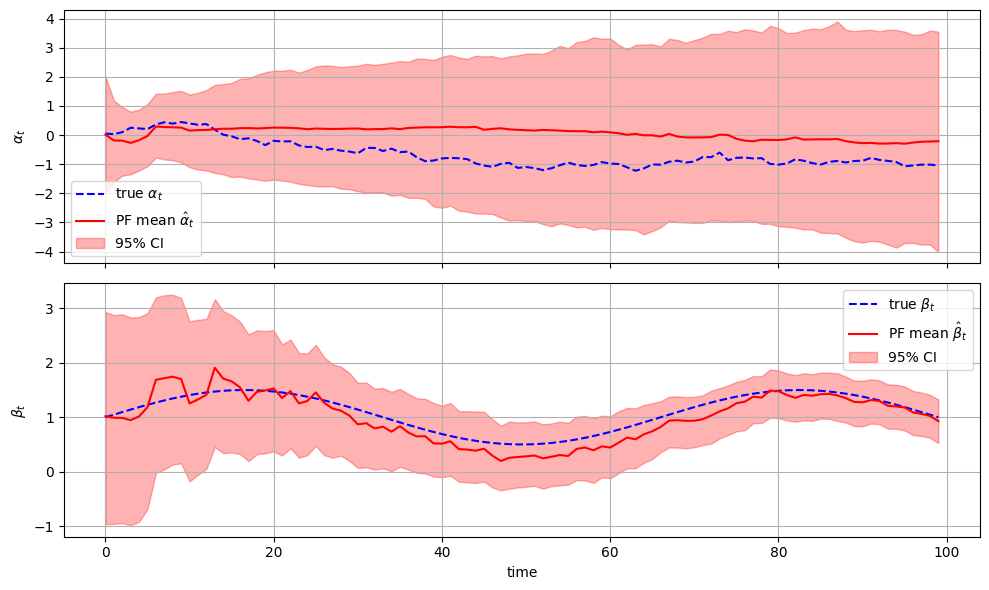

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10,6), sharex=True)

axs[0].plot(alpha_true,  '--', label='true $\\alpha_t$', color='blue')
axs[0].plot(alpha_est,  '-',  label='PF mean $\\hat{\\alpha}_t$', color='r')
axs[0].fill_between(np.arange(T), alpha_lo, alpha_hi, color='r', alpha=0.3, label='95% CI')
axs[0].set_ylabel(r'$\alpha_t$'); axs[0].legend(); axs[0].grid()

axs[1].plot(beta_true,   '--', label='true $\\beta_t$', color='blue')
axs[1].plot(beta_est,   '-',  label='PF mean $\\hat{\\beta}_t$', color='r')
axs[1].fill_between(np.arange(T), beta_lo, beta_hi, color='r', alpha=0.3, label='95% CI')
axs[1].set_ylabel(r'$\beta_t$'); axs[1].legend(); axs[1].grid()
axs[1].set_xlabel('time')

plt.tight_layout()